## Data Preparation

### read data

In [1]:
###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# For reading, processing, and visualizing data
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime

# To make candlestick charts
from mplfinance.original_flavor import candlestick_ohlc

# For reading files
from os import listdir

In [2]:
df = pd.read_csv('sample_data.csv', encoding='utf-8')
df.rename(columns={'Värdepapper/beskrivning': 'company'}, inplace=True)

In [3]:
data_apple = df[df.company == 'Apple Inc']
print(data_apple)

         Datum    Konto Typ av transaktion    company  Antal    Kurs Belopp  \
8   2021/05/14  Nam ISK          Utdelning  Apple Inc     11   1.837  20.21   
9   2021/02/12  Nam ISK          Utdelning  Apple Inc     11   1.703  18.73   
10  2021/02/01  Nam ISK                Köp  Apple Inc      1  131.95  -1123   
11  2020/11/13  Nam ISK          Utdelning  Apple Inc     10   1.775  17.74   
12  2020/10/29  Nam ISK               Sälj  Apple Inc     -9   116.1   9279   
13  2020/09/14  Nam ISK                Köp  Apple Inc      1  114.95  -1020   
14  2020/09/09  Nam ISK                Köp  Apple Inc      2  116.47  -2051   
15  2020/08/28  Nam ISK             Övrigt  Apple Inc     12       -      -   
16  2020/08/25  Nam ISK                Köp  Apple Inc      1     495  -4356   
17  2020/08/14  Nam ISK          Utdelning  Apple Inc      2   7.125  14.24   
18  2020/08/11  Nam ISK                Köp  Apple Inc      1     448  -3948   
19  2020/08/04  Nam ISK                Köp  Apple In

### read stock data

In [4]:
# To create datetime objects 
import datetime

# To grab stock data
import yfinance as fyf
from pandas_datareader import data as pdr
fyf.pdr_override() # <-- Here is the fix

In [5]:
# Set label
stocks = ["AAPL"] # If you want to grab multiple stocks add more labels to this list

# Set start and end dates
start = datetime.datetime(2020, 1, 1)
end   = datetime.datetime(2021, 6, 30)

# Grab data
data = pdr.get_data_yahoo(stocks, start = start, end = end)

[*********************100%***********************]  1 of 1 completed


In [6]:
###############################################################################
#              4a. Visualize Data: Prepare data for Candlestick Chart         #
###############################################################################
# Get Open, High, Low, Close
ADI_candle   = data.iloc[:, 0:4] # Analog Devices

# Get dates
dates = data.index.tolist()
dates = pd.DataFrame(mdates.date2num(dates), columns = ["Date"], index = data.index)

# Add dates column to OHLC DataFrames
ADI_candle = pd.concat([dates, ADI_candle], axis = 1)

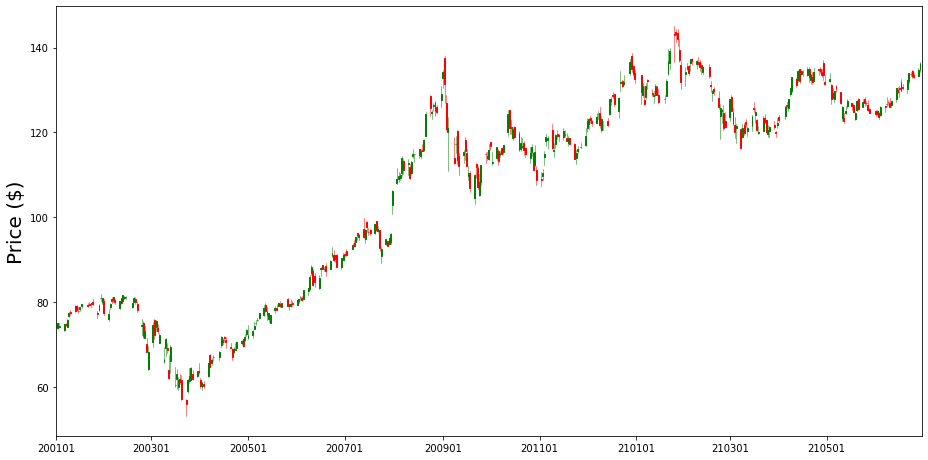

In [7]:
###############################################################################
#                 4b. Visualize Data: Make Candlestick Chart                  #
###############################################################################
# Define time interval to consider
start_date = datetime.date(2020, 1, 1) # Year-Month-Day
end_date   = datetime.date(2021, 6, 30)

# Create figure
fig, ax = plt.subplots(figsize=(13, 6.5))

# Plot ADI_OHLC data
candlestick_ohlc(ax, ADI_candle.values.tolist(), 
                 width=.6, 
                 colorup='green',
                 colordown='red')

# Set x and y axis limits
ax.set_xlim([start_date, end_date])
# ax.set_ylim([60, 69])

# Set axis labels
ax.set_ylabel("Price ($)", fontsize = 20)

# Rotate tick labels
xlabels = ax.get_xticklabels()
# ax.set_xticklabels(xlabels, rotation = 45, fontsize = 14)

# Change x-axis tick label fromat
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y%m%d'))

# Send gridlines to back
ax.set_axisbelow(True)

# Tight layout
plt.tight_layout()


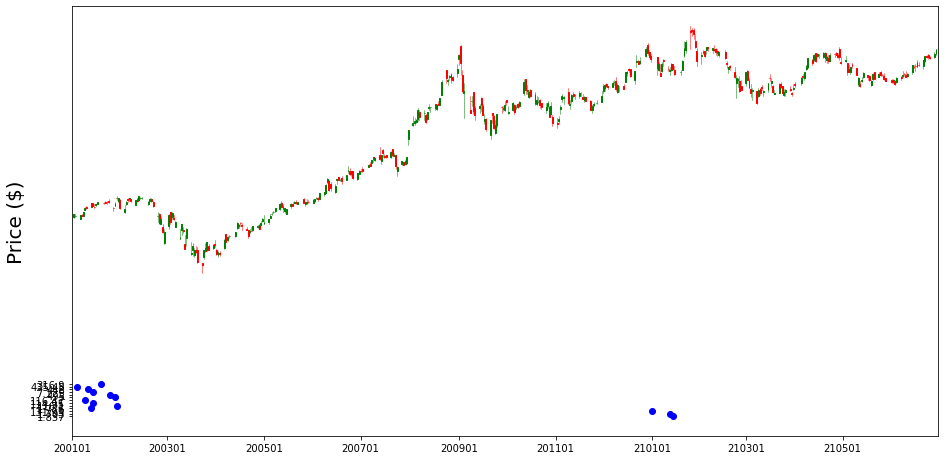

In [8]:
from datetime import datetime as dt
x = []
y = []
for (d,v) in zip(data_apple.Datum, data_apple.Kurs):
    x.append(dt.strptime(d, '%Y/%M/%d'))
    y.append(v)
ax.plot(x,y, marker='o', linestyle='None', color='blue')
fig

ref: https://medium.com/analytics-vidhya/stock-market-trends-b24203484e0f